Variables to determine car speed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing Engine Data
cbf650r_engine_data_file_path = "C:/Users/maxwe/Downloads/FSAE/2023-2024 Car/Repo/engine_data.xlsx"
cbf650r_engine_data = pd.read_excel(cbf650r_engine_data_file_path)

# total weight of car (minus driver) (lbm)
w_car = 569
# weight of driver (lbm)
w_driver = 130
# weight bias, if less than 0.5, then the rear of the car will have more weight, if more than 0.5, then the front will have more weight
w_bias = 0.507
# length of wheelbase (in)
l = 60
# vertical center of gravity (in)
h = 15
# setting pi as a number
pi = 3.14159
# tire grip limit (G's)
a = 1.2
# tire grip limit (in/s^2)
a_ins = a*32.2*12

c:\Users\maxwe\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\maxwe\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


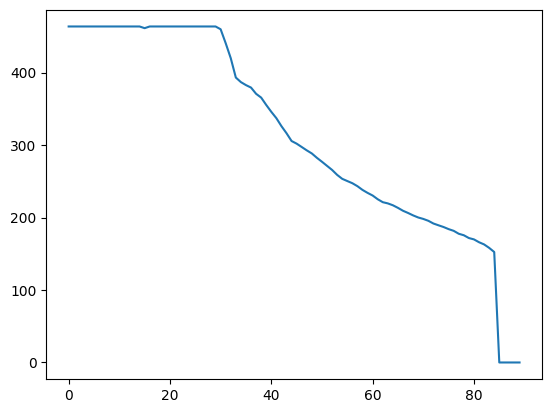

In [2]:
# Simplifying Engine Data
# the force values are kept in their raw form, but the velocity values are rounded to the nearest integer

# Gear 1
g1_vel = list(np.round(cbf650r_engine_data['V1']))
g1_f = list(cbf650r_engine_data['F1'])

# Gear 2
g2_vel = list(np.round(cbf650r_engine_data['V2']))
g2_f = list(cbf650r_engine_data['F2'])

# Gear 3
g3_vel = list(np.round(cbf650r_engine_data['V3']))
g3_f = list(cbf650r_engine_data['F3'])

# Gear 4
g4_vel = list(np.round(cbf650r_engine_data['V4']))
g4_f = list(cbf650r_engine_data['F4'])

# Gear 5
g5_vel = list(np.round(cbf650r_engine_data['V5']))
g5_f = list(cbf650r_engine_data['F5'])

# Gear 6
g6_vel = list(np.round(cbf650r_engine_data['V6']))
g6_f = list(cbf650r_engine_data['F6'])

# Defining new gear force lists that are averaged

g1_f_av = []
g2_f_av = []
g3_f_av = []
g4_f_av = []
g5_f_av = []
g6_f_av = []


for i in np.arange(len(g1_vel[:-3])):
    j1 = g1_vel[i]
    j2 = g2_vel[i]
    j3 = g3_vel[i]
    j4 = g4_vel[i]
    j5 = g5_vel[i]
    j6 = g6_vel[i]
    g1_f_av.append(np.average(g1_f[g1_vel.index(j1):g1_vel.index(j1+1)-1]))
    g2_f_av.append(np.average(g2_f[g2_vel.index(j2):g2_vel.index(j2+1)-1]))
    g3_f_av.append(np.average(g3_f[g3_vel.index(j3):g3_vel.index(j3+1)-1]))
    g4_f_av.append(np.average(g4_f[g4_vel.index(j4):g4_vel.index(j4+1)-1]))
    g5_f_av.append(np.average(g5_f[g5_vel.index(j5):g5_vel.index(j5+1)-1]))
    g6_f_av.append(np.average(g6_f[g6_vel.index(j6):g6_vel.index(j6+1)-1]))

# Cleaning duplicates that were a result of the averaging process:

g1_vel_cln = []
g2_vel_cln = []
g3_vel_cln = []
g4_vel_cln = []
g5_vel_cln = []
g6_vel_cln = []

g1_f_cln = []
g2_f_cln = []
g3_f_cln = []
g4_f_cln = []
g5_f_cln = []
g6_f_cln = []


for i in np.arange(len(g1_vel)-3): # The last 3 data points aren't included because they break the simulator
    if g1_vel[i] not in g1_vel_cln:
        g1_vel_cln.append(g1_vel[i])
    if g2_vel[i] not in g2_vel_cln:
        g2_vel_cln.append(g2_vel[i])
    if g3_vel[i] not in g3_vel_cln:
        g3_vel_cln.append(g3_vel[i])
    if g4_vel[i] not in g4_vel_cln:
        g4_vel_cln.append(g4_vel[i])
    if g5_vel[i] not in g5_vel_cln:
        g5_vel_cln.append(g5_vel[i])
    if g6_vel[i] not in g6_vel_cln:
        g6_vel_cln.append(g6_vel[i])
    
    if g1_f_av[i] not in g1_f_cln:
        g1_f_cln.append(g1_f_av[i])
    if g2_f_av[i] not in g2_f_cln:
        g2_f_cln.append(g2_f_av[i])
    if g3_f_av[i] not in g3_f_cln:
        g3_f_cln.append(g3_f_av[i])
    if g4_f_av[i] not in g4_f_cln:
        g4_f_cln.append(g4_f_av[i])
    if g5_f_av[i] not in g5_f_cln:
        g5_f_cln.append(g5_f_av[i])
    if g6_f_av[i] not in g6_f_cln:
        g6_f_cln.append(g6_f_av[i])

# Dataframe that organizes averaged force values for each gear at a given velocity

# Data for data frame
g_f_d = {'Gear 1' : pd.Series(g1_f_cln, index=g1_vel_cln),
        'Gear 2' : pd.Series(g2_f_cln, index=g2_vel_cln),
        'Gear 3' : pd.Series(g3_f_cln, index=g3_vel_cln),
        'Gear 4' : pd.Series(g4_f_cln, index=g4_vel_cln),
        'Gear 5' : pd.Series(g5_f_cln, index=g5_vel_cln),
        'Gear 6' : pd.Series(g6_f_cln, index=g6_vel_cln),}
g_f_df = pd.DataFrame(data=g_f_d, index=np.arange(int(max(g6_vel)))) # Creating Data Frame
g_f_df = g_f_df.fillna(0) # replacing na values with 0's so the max value can be selected
g_f_array = g_f_df.to_numpy() # converting to a numpy array

# array with all the the max force value at a given velocity
f_array = np.zeros((int(max(g6_vel))))
for i in np.arange(len(g_f_array)):
    f_array[i]= max(g_f_array[i,:]) # getting rid of any force values that aren't the highest

# divides force by car mass to get longitudinal acceleration potential for a given velociy
a_array = f_array/(w_car+w_driver) # acceleration in G's

# replaces any value over the tire limit with the tire limit. 
# Values of zero are also converted to tire limit because it's assumed the driver will be slipping the clutch in this range at the tires limit.
for i in np.arange(len(a_array)):
    if a_array[i] > a:
        a_array[i] = a
    if a_array[i] == 0:
        a_array[i] = a

# accel values converted from G's to in/s^2
a_array = a_array*32.2*12

# Ensuring car can't accelerate past max speed:
a_array = list(a_array)
a_array = a_array+[0,0,0,0,0]

vel_array = np.arange(len(a_array)+5)

# Plots the acceleration potential
plt.plot(np.arange(len(a_array)), a_array)
plt.show()

Simple point-mass simulator: Straight Line

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple straight track when a constant accerleration is applied
- Assumed that the tires are the limiting factor, engine and gearing aren't considered
- boundary conditions require that the initial and final velocity be 0 mph
- This is a super basic model and won't accureately model how fast the car is

total time to travel straight 2.28 seconds


<function matplotlib.pyplot.show(close=None, block=None)>

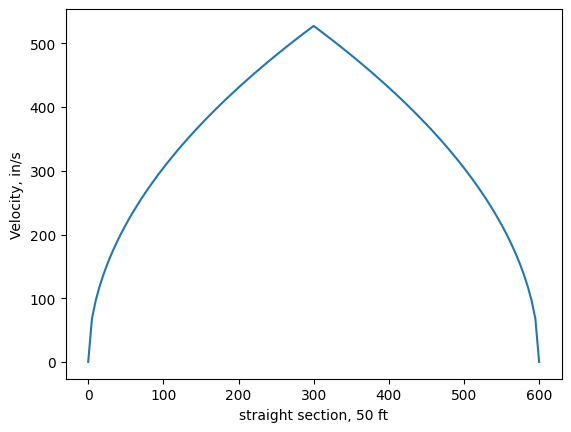

In [3]:
# Run one: How quickly can the car start and stop along a straight line?

# straight line of 50 feet
track = 50
# Convertes track to inches
track = track*12

# discretizing track, dx = length of element (inches), n = number of elements
dx = 5
n = track/dx

# nodespace, nodes = list of x-value for each node in 1D
nodes = np.linspace(0,track,int(n+1))

# a_x is the acceleration limit, which in this model is the coefficient of friction for the tires

a_x = a_ins

# Determine the speed if the car accelerated for the entire length of the traffic, starting from 0 mph at node 0
v1 = np.zeros(int(n+1))
for i in np.arange(n):
    v1[int(i+1)] = np.sqrt(v1[int(i)]**2 + 2*a_x*dx)

# Determine the speed if the car deaccelerated for the entire length of the traffic, ending at 0 mph at node n
v2 = np.zeros(int(n+1))
for i in np.arange(1,n+1):
    v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*a_x*dx)

# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v3 = np.zeros(int(n+1))
for i in np.arange(int(n)):
    if v1[i] < v2 [i]:
        v3[i] = (v1[int(i)])
    else:
        v3[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t = 0
for i in np.arange(len(v3)-1):
    t += np.abs(v3[i+1]-v3[i])/a_x

print(f"total time to travel straight {round(t,2)} seconds")

plt.plot(nodes,v3)
plt.xlabel('straight section, 50 ft')
plt.ylabel('Velocity, in/s')
plt.show

Simple point-mass simulator: Oval Track

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple oval track, where one corner has a radius of 25 ft, and the other corner has a radius of 35 ft. The straights connecting the two sections are both 50 ft.
- Assumed that the tires are the limiting factor, engine and gearing aren't considered
- Constant friction circle of 2.2 G's
- boundary conditions require that the initial velocity be 0 mph
- This is a super basic model and won't accureately model how fast the car is!

total time to travel straight 2.81 seconds
total track distance = 288.5 ft


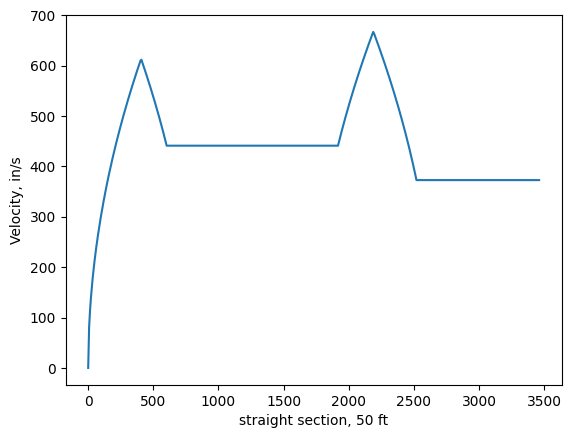

In [4]:
# Run one: How quickly can the car start and stop along a straight line?

# Track components

# straight's,  line of 50 feet
t = np.array([50*12, pi*35*12, 50*12, pi*25*12])
track = np.sum(t)

# discretizing track
n = 500
dx = track/n

# nodespace
nodes = np.linspace(0,track,int(n+1))

# Acceleration limited by grip of tires
a = a_ins

# Determining maximum lateral acceleration for the two corners

# 35 ft corner
v_c1 = np.sqrt(a*35*12)
# 25 ft corner
v_c2 = np.sqrt(a*25*12)

# Determine the speed if the car accelerated for the entire length of the traffic, starting from 0 mph at node 0
v1 = np.zeros(int(n+1))
v1[int(np.ceil(t[0]/dx)):int(np.ceil((t[0]+t[1])/dx))] = v_c1
v1[int(np.ceil((t[0]+t[1]+t[2])/dx)):] = v_c2
for i in np.arange(n):
    if (np.sqrt(v1[int(i)]**2 + 2*a*dx) < v1[int(i+1)]) or (v1[int(i+1)] == 0.):
        v1[int(i+1)] = np.sqrt(v1[int(i)]**2 + 2*a*dx)

# Determine the speed if the car deaccelerated for the entire length of the traffic, ending at 0 mph at node n
v2 = np.zeros(int(n+1))
v2[int(np.ceil(t[0]/dx)):int(np.ceil((t[0]+t[1])/dx))] = v_c1
v2[int(np.ceil((t[0]+t[1]+t[2])/dx)):] = v_c2
for i in np.arange(1,n+1):
    if (np.sqrt(v2[int(-i)]**2 + 2*a*dx) < v2[int(-i-1)]) or (v2[int(-i-1)] == 0.):
        v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*a*dx)

# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v3 = np.zeros(int(n+1))
for i in np.arange(int(n+1)):
    if v1[i] < v2 [i]:
        v3[i] = (v1[int(i)])
    else:
        v3[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t = 0
for i in np.arange(len(v3)-1):
    t += np.abs(v3[i+1]-v3[i])/a
print(f"total time to travel straight {round(t,2)} seconds")

# Plotting result
plt.plot(nodes,v3)
plt.xlabel('straight section, 50 ft')
plt.ylabel('Velocity, in/s')
plt.show
print(f"total track distance = {round(track/12, 2)} ft")

Simple point-mass simulator: Oval Track with Curved Straights

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple oval track, where one corner has a radius of 25 ft, and the other corner has a radius of 35 ft. The straights connecting the two sections are both 50 ft.
- Assumed that the tires are the limiting factor, engine and gearing aren't considered
- Constant friction circle of 2.2 G's
- boundary conditions require that the initial velocity be 0 mph
- This is a super basic model and won't accureately model how fast the car is!

total time to travel straight 2.72 seconds
total track distance = 288.5 ft


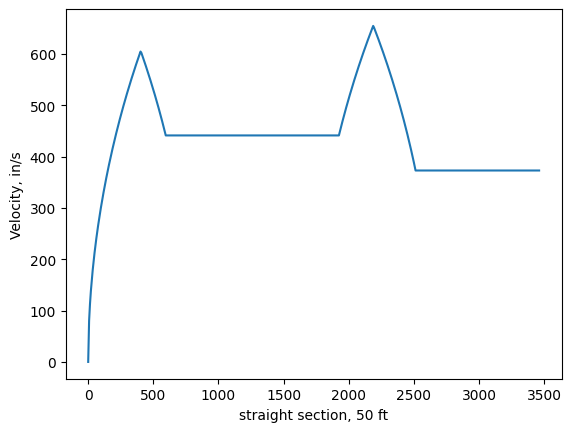

In [5]:
# Run one: How quickly can the car start and stop along a straight line?

# Track components

# Determining the shape of the track

# Each element in the t_rad list corresponds to the radius of that element (in)
t_rad = np.array([200*12, 35*12, 200*12, 25*12])
# Each element in the t_len list corresponds to the length of that element (rad)
t_len = np.array([(1/4), pi, (1/4), pi])
# Determines the length of each element (inches)
t_len_tot = np.multiply(t_rad,t_len)
# Determines total length of track
track = np.sum(t_len_tot)

# discretizing track, n = number of elements, dx = length of element (inches)
n = 500
dx = track/n

# nodespace
nds = np.linspace(0,track,int(n+1))

# Maximum acceleration determined by the grip limit of the tires
a = a_ins

# Determining maximum lateral acceleration for every turn
t_vel = np.sqrt(a*t_rad)

# List showing radius at every node. Used to calculate maximum tangential acceleration
nd_rad = np.zeros(int(n+1))

# Each line sets the maximum velocity for each 
nd_rad[0:int(np.ceil(t_len_tot[0]/dx))] = t_rad[0]
nd_rad[int(np.ceil(t_len_tot[0]/dx)):int(np.ceil(np.sum(t_len_tot[0:2])/dx))] = t_rad[1]
nd_rad[int(np.ceil(np.sum(t_len_tot[0:2])/dx)):int(np.ceil(np.sum(t_len_tot[0:3])/dx))] = t_rad[2]
nd_rad[int(np.ceil((np.sum(t_len_tot[0:3]))/dx)):] = t_rad[3]

# Determine the speed if the car accelerated for the entire length of the traffic, starting from 0 mph at node 0
v1 = np.zeros(int(n+1))

v1[0:int(np.ceil(t_len_tot[0]/dx))] = t_vel[0]
v1[int(np.ceil(t_len_tot[0]/dx)):int(np.ceil(np.sum(t_len_tot[0:2])/dx))] = t_vel[1]
v1[int(np.ceil(np.sum(t_len_tot[0:2])/dx)):int(np.ceil(np.sum(t_len_tot[0:3])/dx))] = t_vel[2]
v1[int(np.ceil((np.sum(t_len_tot[0:3]))/dx)):] = t_vel[3]
v1[0] = 0

for i in np.arange(n):
    a_tan = np.sqrt(abs(a**2 - ((v1[i]**4)/(nd_rad[i]**2))))
    if (np.sqrt(v1[int(i)]**2 + 2*a_tan*dx) < v1[int(i+1)]) or (v1[int(i+1)] == 0.):
        v1[int(i+1)] = np.sqrt(v1[int(i)]**2 + 2*a_tan*dx)

# Determine the speed if the car deaccelerated for the entire length of the traffic, ending at 0 mph at node n
v2 = np.zeros(int(n+1))
v2[0:int(np.ceil(t_len_tot[0]/dx))] = t_vel[0]
v2[int(np.ceil(t_len_tot[0]/dx)):int(np.ceil(np.sum(t_len_tot[0:2])/dx))] = t_vel[1]
v2[int(np.ceil(np.sum(t_len_tot[0:2])/dx)):int(np.ceil(np.sum(t_len_tot[0:3])/dx))] = t_vel[2]
v2[int(np.ceil((np.sum(t_len_tot[0:3]))/dx)):] = t_vel[3]

for i in np.arange(1,n+1):
    a_tan = np.sqrt(abs(a**2 - ((v2[-i]**4)/(nd_rad[-i]**2))))
    if (np.sqrt(v2[int(-i)]**2 + 2*a_tan*dx) < v2[int(-i-1)]) or (v2[int(-i-1)] == 0.):
        v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*a_tan*dx)


# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v3 = np.zeros(int(n+1))
for i in np.arange(int(n+1)):
    if v1[i] < v2 [i]:
        v3[i] = (v1[int(i)])
    else:
        v3[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t = 0
for i in np.arange(len(v2)-1):
    t += np.abs(v3[i+1]-v3[i])/a
print(f"total time to travel straight {round(t,2)} seconds")

# Plotting result
plt.plot(nds,v3)
plt.xlabel('straight section, 50 ft')
plt.ylabel('Velocity, in/s')
plt.show
print(f"total track distance = {round(track/12, 2)} ft")

Simple point-mass simulator: Straight Line w/Engine Data

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple straight track when tire grip limits and engine power limits are applied
- Assumed that the tires, engine, and gearing are the limiting factor, aero effects not considered
- boundary conditions require that the initial and final velocity be 0 mph
- This is a super basic model and won't accureately model how fast the car is

total time to travel straight 4.6 seconds


<function matplotlib.pyplot.show(close=None, block=None)>

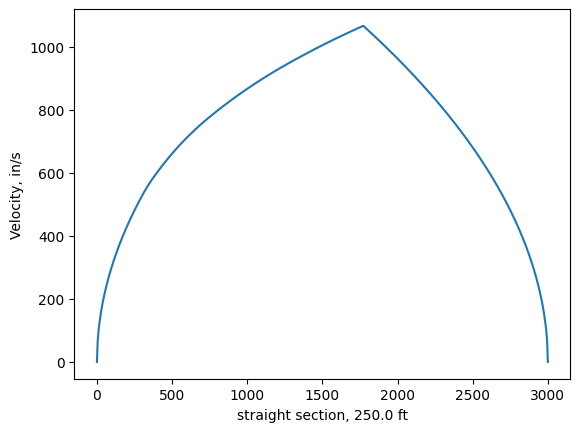

In [6]:
# Run one: How quickly can the car start and stop along a straight line?

# Length of straight track in ft
track = 250
# Convertes track to inches
track = track*12

# discretizing track
dx = 5
n = track/dx

# nodespace
nodes = np.linspace(0,track,int(n+1))

# Determine the speed if the car accelerated for the entire length of the track, starting from 0 mph at node 0
v1 = np.zeros(int(n+1))
for i in np.arange(n):
    v1[int(i+1)] = np.sqrt(v1[int(i)]**2 + 2*a_array[int(round(v1[int(i)]/17.6))]*dx)

# Determine the speed if the car deaccelerated for the entire length of the track, ending at 0 mph at node n
v2 = np.zeros(int(n+1))
for i in np.arange(1,n+1):
    v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*a_ins*dx)

# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v4 = np.zeros(int(n+1))
for i in np.arange(int(n)):
    if v1[i] < v2 [i]:
        v4[i] = (v1[int(i)])
    else:
        v4[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t = 0
for i in np.arange(len(v4)-1):
    t += np.abs(v4[i+1]-v4[i])/a

print(f"total time to travel straight {round(t,2)} seconds")

plt.plot(nodes,v4)
plt.xlabel(f'straight section, {track/12} ft')
plt.ylabel('Velocity, in/s')
plt.show

Simple point-mass simulator: Oval Track, Curved Straights, Engine Data

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple oval track, where one corner has a radius of 25 ft, and the other corner has a radius of 35 ft. The straights connecting the two sections are both 50 ft.
- Assumed that the tires, engine, and gearing are the limiting factor, aero effects not considered
- Constant friction circle of 2.2 G's
- boundary conditions require that the initial velocity be 0 mph
- This is a super basic model and won't accureately model how fast the car is!

total time to travel straight 2.72 seconds
total track distance = 288.5 ft


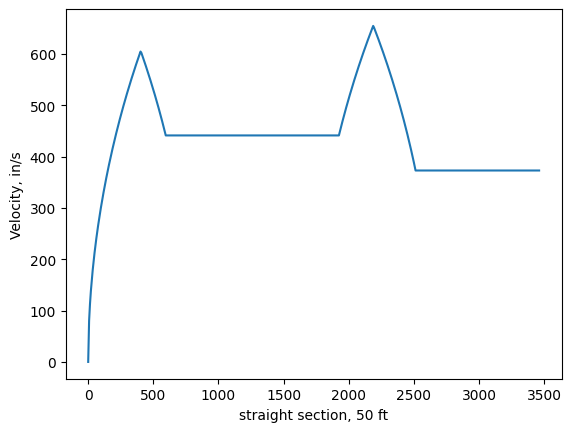

In [7]:
# Run one: How quickly can the car start and stop along a straight line?

# Track components

# Determining the shape of the track

# Each element in the t_rad list corresponds to the radius of that element (in)
t_rad = np.array([200*12, 35*12, 200*12, 25*12])
# Each element in the t_len list corresponds to the length of that element (rad)
t_len = np.array([(1/4), pi, (1/4), pi])
t_len_tot = np.multiply(t_rad,t_len)
track = np.sum(t_len_tot)

# discretizing track
n = 500
dx = track/n

# nodespace
nds = np.linspace(0,track,int(n+1))


# Determining maximum lateral acceleration for every turn
t_vel = np.sqrt(a*t_rad)

# List showing radius at every node. Used to calculate maximum tangential acceleration
nd_rad = np.zeros(int(n+1))

nd_rad[0:int(np.ceil(t_len_tot[0]/dx))] = t_rad[0]
nd_rad[int(np.ceil(t_len_tot[0]/dx)):int(np.ceil(np.sum(t_len_tot[0:2])/dx))] = t_rad[1]
nd_rad[int(np.ceil(np.sum(t_len_tot[0:2])/dx)):int(np.ceil(np.sum(t_len_tot[0:3])/dx))] = t_rad[2]
nd_rad[int(np.ceil((np.sum(t_len_tot[0:3]))/dx)):] = t_rad[3]

# Determine the speed if the car accelerated for the entire length of the traffic, starting from 0 mph at node 0
v1 = np.zeros(int(n+1))

v1[0:int(np.ceil(t_len_tot[0]/dx))] = t_vel[0]
v1[int(np.ceil(t_len_tot[0]/dx)):int(np.ceil(np.sum(t_len_tot[0:2])/dx))] = t_vel[1]
v1[int(np.ceil(np.sum(t_len_tot[0:2])/dx)):int(np.ceil(np.sum(t_len_tot[0:3])/dx))] = t_vel[2]
v1[int(np.ceil((np.sum(t_len_tot[0:3]))/dx)):] = t_vel[3]
v1[0] = 0

for i in np.arange(n):
    a_tan = np.sqrt(abs(a**2 - ((v1[i]**4)/(nd_rad[i]**2))))
    if (np.sqrt(v1[int(i)]**2 + 2*a_tan*dx) < v1[int(i+1)]) or (v1[int(i+1)] == 0.):
        v1[int(i+1)] = np.sqrt(v1[int(i)]**2 + 2*a_tan*dx)

# Determine the speed if the car deaccelerated for the entire length of the traffic, ending at 0 mph at node n
v2 = np.zeros(int(n+1))
v2[0:int(np.ceil(t_len_tot[0]/dx))] = t_vel[0]
v2[int(np.ceil(t_len_tot[0]/dx)):int(np.ceil(np.sum(t_len_tot[0:2])/dx))] = t_vel[1]
v2[int(np.ceil(np.sum(t_len_tot[0:2])/dx)):int(np.ceil(np.sum(t_len_tot[0:3])/dx))] = t_vel[2]
v2[int(np.ceil((np.sum(t_len_tot[0:3]))/dx)):] = t_vel[3]

for i in np.arange(1,n+1):
    a_tan = np.sqrt(abs(a**2 - ((v2[-i]**4)/(nd_rad[-i]**2))))
    if (np.sqrt(v2[int(-i)]**2 + 2*a_tan*dx) < v2[int(-i-1)]) or (v2[int(-i-1)] == 0.):
        v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*a_tan*dx)


# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v3 = np.zeros(int(n+1))
for i in np.arange(int(n+1)):
    if v1[i] < v2 [i]:
        v3[i] = (v1[int(i)])
    else:
        v3[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t = 0
for i in np.arange(len(v2)-1):
    t += np.abs(v3[i+1]-v3[i])/a
print(f"total time to travel straight {round(t,2)} seconds")

# Plotting result
plt.plot(nds,v3)
plt.xlabel('straight section, 50 ft')
plt.ylabel('Velocity, in/s')
plt.show
print(f"total track distance = {round(track/12, 2)} ft")